# 语义分析

## GluonCV + MXNet

In [2]:
# 导入需要使用的包
import os
import mxnet as mx
from mxnet import image
import gluoncv
from gluoncv.data.transforms.presets.segmentation import test_transform
from gluoncv.utils.viz import get_color_pallete,plot_image
from gluoncv import model_zoo, data, utils
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

# 忽略警告
import warnings; warnings.filterwarnings(action='once') 
warnings.filterwarnings("ignore")

C:\Users\JZY\AppData\Roaming\Python\Python38\site-packages\gluoncv\__init__.py:40: UserWarning: Both `mxnet==1.7.0` and `torch==1.8.1` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [3]:
# 设定使用GPU或者CUP进行计算，没有安装GPU版本的MXNet请使用CPU
ctx = mx.cpu()

# 定义函数对单张图片进行图像分割，并将结果存为pd.Series
def get_seg(file, model):
    img = image.imread(file)
    img = test_transform(img,ctx=ctx)
    output = model.predict(img)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()
    
    # 定义Cityscapes数据集分割标签字典
    col_map = {0:'road', 1:'sidewalk', 2:'building', 3:'wall', 4:'fence', 5:'pole', 6:'traffic light',
               7:'traffic sign', 8:'vegetation', 9:'terrain', 10:'sky', 11:'person', 12:'rider',
               13:'car', 14:'truck', 15:'bus', 16:'train', 17:'motorcycle', 18:'bicycle'}
    pred = []
    for i in range(19):
        pred.append((len(predict[predict==i])/(predict.shape[0]*predict.shape[1])))
    pred = pd.Series(pred).rename(col_map)
    return pred

In [4]:
# 下载模型，这里使用的是在Cityscapes数据集上预训练的PSPnet模型
model = model_zoo.get_model('psp_resnet101_ade',ctx=ctx,pretrained=True)

self.crop_size 480


In [13]:
Set_path = r'E:\picture' # 传入保存地址街景集目录的文件夹路径
loclist = os.listdir(Set_path)
col_map = {0:'road', 1:'sidewalk', 2:'building', 3:'wall', 4:'fence', 5:'pole', 6:'traffic light',
               7:'traffic sign', 8:'vegetation', 9:'terrain', 10:'sky', 11:'person', 12:'rider',
               13:'car', 14:'truck', 15:'bus', 16:'train', 17:'motorcycle', 18:'bicycle'}

#定义语义表表头，即分割类别
df = pd.DataFrame(columns=['id','lng','lat','road','sidewalk','building','wall','fence',
                           'pole','traffic light','traffic sign','vegetation','terrain','sky',
                           'person','rider','car','truck','bus','train','motorcycle','bicycle'])
EV = pd.DataFrame(columns=['id','lng','lat','Sky-view Factor','Green Looking Ratio'])

for loc in loclist: # 循环遍历所有地址街景集
    #对每一个地点的三张图片进行语义分割，将分割结果进行加权求和
    loc_path = Set_path + "/" + loc
    imglist = os.listdir(loc_path)
    try:
        loc_id = float(loc[8:].split('_')[0])
    except:
        continue
    else:
        lng = float(loc[8:].split('_')[1])
        lat = float(loc[8:].split('_')[2])
        
        #每次初始化一个保存本次遍历地点的三个方向图像分割结果均值的series
        data_temp = pd.Series([0]*19).rename(col_map)
        for i in imglist:
            img_path = loc_path + "/" + i
            try:
                img_id = float(i[1:-4].split('_')[0])
            except:
                continue
            else:
                data_temp += get_seg(img_path, model)
                
        #一个地点的所有图片的总体语义分割结果
        data_values = data_temp.values.tolist()
        data_values = [float(dv)/sum(data_values) for dv in data_values]
        data_loc = pd.Series({'id':loc_id, 'lng':lng, 'lat':lat}).append(pd.Series(data_values).rename(col_map))
        print('----------[地址' + loc + '已完成分割计算]--------')     
        
        df = pd.concat([df, pd.DataFrame(data_loc).T], axis=0, join='outer', ignore_index=True)
        
df.to_csv("E:\\SRTP\\Feature2_part0.csv") # 将结果保存到csv

|>--------图片.0.0_118.709403608_32.026875284_115.jpg已完成分割计算--------
|>--------图片.0.0_118.709403608_32.026875284_295.jpg已完成分割计算--------
----------[地址location0.0_118.709403608_32.026875284已完成分割计算]--------
|>--------图片.20.0_118.70947581_32.025678251_115.jpg已完成分割计算--------
|>--------图片.20.0_118.70947581_32.025678251_295.jpg已完成分割计算--------
----------[地址location20.0_118.70947581_32.025678251已完成分割计算]--------
|>--------图片.40.0_118.720117602_32.024420293_115.jpg已完成分割计算--------
|>--------图片.40.0_118.720117602_32.024420293_295.jpg已完成分割计算--------
----------[地址location40.0_118.720117602_32.024420293已完成分割计算]--------
|>--------图片.60.0_118.708177601_32.023251858_115.jpg已完成分割计算--------
|>--------图片.60.0_118.708177601_32.023251858_295.jpg已完成分割计算--------
----------[地址location60.0_118.708177601_32.023251858已完成分割计算]--------
|>--------图片.80.0_118.727691857_32.023644683_115.jpg已完成分割计算--------
|>--------图片.80.0_118.727691857_32.023644683_295.jpg已完成分割计算--------
----------[地址location80.0_118.727691857_32.0236446

|>--------图片.780.0_118.715919304_32.016336831_115.jpg已完成分割计算--------
|>--------图片.780.0_118.715919304_32.016336831_295.jpg已完成分割计算--------
----------[地址location780.0_118.715919304_32.016336831已完成分割计算]--------


In [ ]:
df.to_csv("E:\\SRTP\\Feature2_part2.csv")

## 3D特征维度计算

In [17]:
import xlrd
#读取语义分割结果
data_csv = pd.read_csv('C:\\Users\\JZY\\Desktop\\3d.csv')
data = pd.DataFrame(data_csv)

#定义街景特征
loc_id = pd.DataFrame(np.array(data['id']),columns=['ID'],dtype=float)
lng = pd.DataFrame(np.array(data['lng']),columns=['LNG'],dtype=float)
lat = pd.DataFrame(np.array(data['lat']),columns=['LAT'],dtype=float)
#1.天空开敞度
Sky_vf = pd.DataFrame(np.array(data['sky']),columns=['SkyViewFactor'],dtype=float)

#2.绿视率
Green_lr = pd.DataFrame(np.array(data['vegetation']),columns=['GreenLookingRatio'],dtype=float)

#3.围合度
Enclosure_den = []
#防止分母为0
for x in (np.array(data['fence'])+np.array(data['sidewalk'])+np.array(data['road'])):
    if x ==0:
        Enclosure_den.append(100)
    else:
        Enclosure_den.append(x)
Enclosure = (np.array(data['wall'])+np.array(data['building'])+np.array(data['vegetation']))/np.array(Enclosure_den)
Enclosure = pd.DataFrame(Enclosure,columns=['Enclosure'],dtype=float)

#4.路面（行人）可行性
PaveFea = 1+(np.array(data['sidewalk'])+np.array(data['person'])-np.array(data['traffic light'])-np.array(data['road'])-np.array(data['bus'])-np.array(data['truck'])-np.array(data['car']))
PaveFea = pd.DataFrame(PaveFea,columns=['PavementFeasibility'],dtype=float)

Feature = pd.concat([loc_id,lng,lat,Sky_vf,Green_lr,Enclosure,PaveFea], axis=1)
Feature.to_csv("C:\\Users\\JZY\\Desktop\\Feature_comprass_final_2.csv")
print(Feature)


           ID         LNG        LAT  SkyViewFactor  GreenLookingRatio  \
0         0.0  118.709404  32.026875       0.261667           0.119444   
1        20.0  118.709476  32.025678       0.171665           0.212198   
2        40.0  118.720118  32.024420       0.055741           0.153368   
3        60.0  118.708178  32.023252       0.207717           0.105420   
4        80.0  118.727692  32.023645       0.062434           0.295856   
...       ...         ...        ...            ...                ...   
996   19920.0  118.820284  32.081775       0.057535           0.275677   
997   19940.0  118.820992  32.081890       0.062929           0.160097   
998   19960.0  118.824978  32.081720       0.049628           0.397550   
999   19980.0  118.778932  32.081064       0.096356           0.318234   
1000  20000.0  118.787456  32.081222       0.000000           0.052167   

      Enclosure  PavementFeasibility  
0      0.250080             0.469878  
1      0.488257             0.571

## 分割结果可视化

(-0.5, 1021.5, 607.5, -0.5)

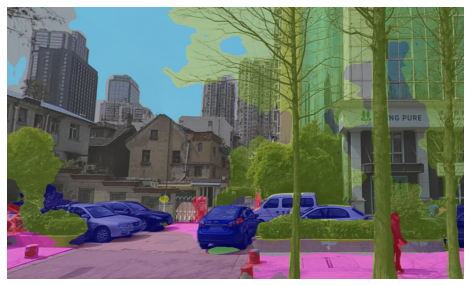

In [26]:
# 对单张图片进行可视化
img_path = r'D:\JupyterNotebook\Project\StreetPic\01_01_01_01_jxh.jpg'
img = image.imread(img_path)
img = test_transform(img,ctx=ctx)
output = model.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = get_color_pallete(predict, 'citys')
base = mpimg.imread(img_path)
plt.figure(figsize=(10,5))
plt.imshow(base)
plt.imshow(mask,alpha=0.5)
plt.axis('off')
#plt.savefig(".",dpi=150,bbox_inches='tight')


(-0.5, 1158.5, 600.5, -0.5)

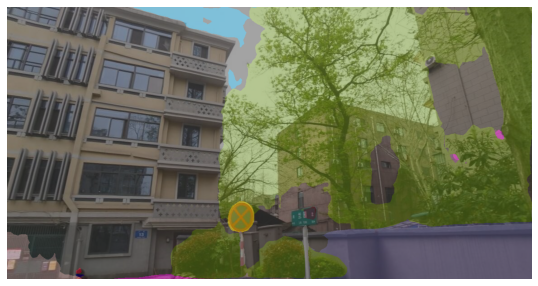

In [46]:
# 对单张图片进行可视化
img_path = r'D:\JupyterNotebook\Project\StreetPic\02_01_02_01_jxh.jpg'
img = image.imread(img_path)
img = test_transform(img,ctx=ctx)
output = model.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = get_color_pallete(predict, 'citys')
base = mpimg.imread(img_path)
plt.figure(figsize=(10,5))
plt.imshow(base)
plt.imshow(mask,alpha=0.5)
plt.axis('off')
#plt.savefig(".",dpi=150,bbox_inches='tight')


(-0.5, 1032.5, 620.5, -0.5)

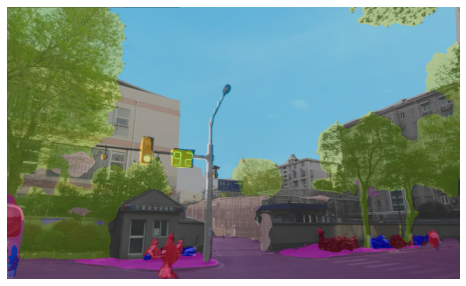

In [45]:
# 对单张图片进行可视化
img_path = r'D:\JupyterNotebook\Project\StreetPic\02_01_01_01_jxh.jpg'
img = image.imread(img_path)
img = test_transform(img,ctx=ctx)
output = model.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = get_color_pallete(predict, 'citys')
base = mpimg.imread(img_path)
plt.figure(figsize=(10,5))
plt.imshow(base)
plt.imshow(mask,alpha=0.5)
plt.axis('off')
#plt.savefig(".",dpi=150,bbox_inches='tight')


(-0.5, 1038.5, 610.5, -0.5)

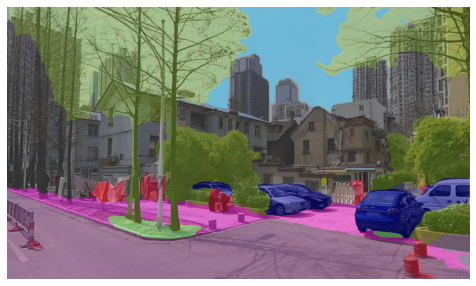

In [27]:
# 对单张图片进行可视化
img_path = r'D:\JupyterNotebook\Project\StreetPic\01_01_01_02_jxh.jpg'
img = image.imread(img_path)
img = test_transform(img,ctx=ctx)
output = model.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = get_color_pallete(predict, 'citys')
base = mpimg.imread(img_path)
plt.figure(figsize=(10,5))
plt.imshow(base)
plt.imshow(mask,alpha=0.5)
plt.axis('off')
#plt.savefig(".",dpi=150,bbox_inches='tight')


(-0.5, 1040.5, 575.5, -0.5)

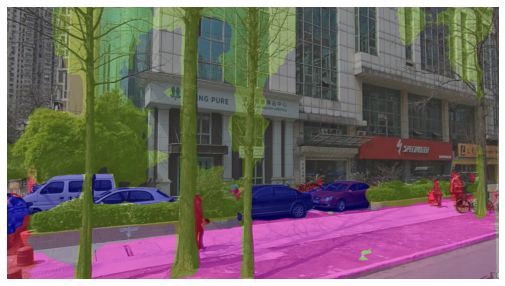

In [28]:
# 对单张图片进行可视化
img_path = r'D:\JupyterNotebook\Project\StreetPic\01_01_01_03_jxh.jpg'
img = image.imread(img_path)
img = test_transform(img,ctx=ctx)
output = model.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

mask = get_color_pallete(predict, 'citys')
base = mpimg.imread(img_path)
plt.figure(figsize=(10,5))
plt.imshow(base)
plt.imshow(mask,alpha=0.5)
plt.axis('off')
#plt.savefig(".",dpi=150,bbox_inches='tight')


## 数据表可视化

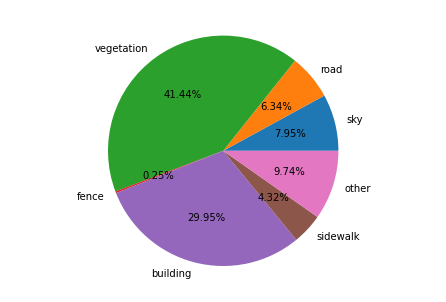

In [43]:
import matplotlib.pyplot as plt
#添加图形对象
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#使得X/Y轴的间距相等
ax.axis('equal')
# 数据准备
nums = [0.079517072,0.063436631,0.414418967,0.002486417,0.29954649,0.043173537,0.013183644+0.063114765+0.017881283+0.000870648+0.000431301+0.000537517+0.001401728]
labels = ['sky','road','vegetation','fence','building','sidewalk','other']
# 用Matplotlib画饼图
plt.pie(x = nums, labels=labels,autopct='%1.2f%%')

plt.show()
